# Oil Spill Detection - Advanced Data Preprocessing
## AI-Driven System for Oil Spill Identification and Monitoring

This notebook contains comprehensive preprocessing for SAR and RGB satellite imagery oil spill detection.

## 1. Import Required Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import ndimage
from skimage import filters, exposure
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Dataset Configuration

In [2]:
# Dataset paths
DATASET_PATH = "DataSet"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# Image configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3
IMAGE_TYPE = 'RGB'  # Change to 'SAR' for SAR images

print(f"Dataset path: {DATASET_PATH}")
print(f"Image type: {IMAGE_TYPE}")
print(f"Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")

Dataset path: DataSet
Image type: RGB
Image size: 256x256x3


## 3. Dataset Exploration

In [3]:
def count_files(path):
    """Count number of files in images and masks folders"""
    images_path = os.path.join(path, "images")
    masks_path = os.path.join(path, "masks")
    
    if os.path.exists(images_path) and os.path.exists(masks_path):
        img_count = len([f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        mask_count = len([f for f in os.listdir(masks_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        return img_count, mask_count
    return 0, 0

# Count files in each split
train_imgs, train_masks = count_files(TRAIN_PATH)
val_imgs, val_masks = count_files(VAL_PATH)
test_imgs, test_masks = count_files(TEST_PATH)

print("Dataset Statistics:")
print(f"Train: {train_imgs} images, {train_masks} masks")
print(f"Validation: {val_imgs} images, {val_masks} masks")
print(f"Test: {test_imgs} images, {test_masks} masks")
print(f"Total: {train_imgs + val_imgs + test_imgs} images")

Dataset Statistics:
Train: 811 images, 811 masks
Validation: 203 images, 203 masks
Test: 254 images, 254 masks
Total: 1268 images


## 4. SAR-Specific Preprocessing Functions

In [4]:
# import sarpy
# from sarpy.processing.speckle import lee_filter

# def preprocess_sar(image, method='lee'):
#     """Preprocess SAR image: speckle noise reduction + normalization"""
    
#     # 1. Speckle noise reduction (using built-in Lee filter)
#     if method == 'lee':
#         image = lee_filter(image, window_size=5)  # sarpy's Lee filter
    
#     # 2. Log scaling + z-score normalization
#     image = np.log(image + 1e-10)
#     image = (image - image.mean()) / (image.std() + 1e-10)
    
#     # 3. Scale to [0,1]
#     image = (image - image.min()) / (image.max() - image.min() + 1e-10)
    
#     return image.astype(np.float32)


# def preprocess_rgb(image):
#     """Normalize RGB image to [0,1]"""
#     return image.astype(np.float32)/255.0

# print("Preprocessing functions ready!")
import numpy as np
from scipy.ndimage import uniform_filter


def lee_filter(img, window_size=5):
    """
    Lee speckle filter for SAR images.
    img : 2D numpy array (SAR image)
    window_size : size of local filter window
    """
    img = img.astype(np.float32)

    # Local mean & variance
    img_mean = uniform_filter(img, window_size)
    img_sqr_mean = uniform_filter(img**2, window_size)
    img_variance = img_sqr_mean - img_mean**2

    # Noise variance (whole image variance)
    overall_variance = np.var(img)

    # Lee filter formula
    weights = img_variance / (img_variance + overall_variance + 1e-10)
    lee_img = img_mean + weights * (img - img_mean)

    return lee_img


def preprocess_sar(image, method='lee'):
    """Preprocess SAR image: speckle noise reduction + normalization"""
    
    # 1. Speckle noise reduction
    if method == 'lee':
        image = lee_filter(image, window_size=5)
    
    # 2. Log scaling + z-score normalization
    image = np.log(image + 1e-10)
    image = (image - image.mean()) / (image.std() + 1e-10)
    
    # 3. Scale to [0,1]
    image = (image - image.min()) / (image.max() - image.min() + 1e-10)
    
    return image.astype(np.float32)


def preprocess_rgb(image):
    """Normalize RGB image to [0,1]"""
    return image.astype(np.float32) / 255.0


print("Preprocessing functions ready!")


Preprocessing functions ready!


## 5. Image Preprocessing Functions

In [5]:
def load_image(image_path, image_type='RGB'):
    """Load and preprocess image"""
    if image_type == 'SAR':
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = preprocess_sar(img.astype(np.float32)/255.0)
        img = np.stack([img, img, img], axis=-1)
    else:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = preprocess_rgb(img)
    return img

def load_mask(mask_path):
    """Load and preprocess mask"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 127).astype(np.float32)
    return mask

print("Image preprocessing functions ready!")

Image preprocessing functions ready!


## 6. Data Augmentation Functions

In [6]:
# def geometric_augmentation(image, mask):
#     """Apply geometric augmentations"""
#     # Random horizontal flip
#     if np.random.random() > 0.5:
#         image = np.fliplr(image)
#         mask = np.fliplr(mask)
    
#     # Random vertical flip
#     if np.random.random() > 0.5:
#         image = np.flipud(image)
#         mask = np.flipud(mask)
    
#     # Random rotation (90, 180, 270 degrees)
#     k = np.random.randint(0, 4)
#     image = np.rot90(image, k)
#     mask = np.rot90(mask, k)
    
#     return image, mask

# def photometric_augmentation(image, image_type='RGB'):
#     """Apply photometric augmentations"""
#     if image_type == 'RGB':
#         # Brightness variation
#         if np.random.random() > 0.5:
#             brightness = np.random.uniform(0.8, 1.2)
#             image = np.clip(image * brightness, 0, 1)
        
#         # Contrast variation
#         if np.random.random() > 0.5:
#             contrast = np.random.uniform(0.8, 1.2)
#             image = np.clip((image - 0.5) * contrast + 0.5, 0, 1)
        
#         # Random noise injection
#         if np.random.random() > 0.7:
#             noise = np.random.normal(0, 0.02, image.shape)
#             image = np.clip(image + noise, 0, 1)
    
#     elif image_type == 'SAR':
#         # SAR-specific augmentations
#         if np.random.random() > 0.5:
#             speckle = np.random.gamma(1, 0.1, image.shape)
#             image = np.clip(image * speckle, 0, 1)
        
#         if np.random.random() > 0.5:
#             scale = np.random.uniform(0.9, 1.1)
#             image = np.clip(image * scale, 0, 1)
    
#     return image

# print("Data augmentation functions ready!")

# ____________________________________________________________________
def geometric_augmentation(image, mask):
    """Apply geometric augmentations"""
    # Random horizontal flip
    if np.random.random() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    
    # Random vertical flip
    if np.random.random() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    
    # Random rotation (90, 180, 270 degrees)
    k = np.random.randint(0, 4)
    image = np.rot90(image, k)
    mask = np.rot90(mask, k)
    
    return image, mask

def photometric_augmentation(image, image_type='RGB'):
    """Apply photometric augmentations"""
    if image_type == 'RGB':
        # Brightness variation
        if np.random.random() > 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            image = np.clip(image * brightness, 0, 1)
        
        # Contrast variation
        if np.random.random() > 0.5:
            contrast = np.random.uniform(0.8, 1.2)
            image = np.clip((image - 0.5) * contrast + 0.5, 0, 1)
        
        # Random noise injection
        if np.random.random() > 0.7:
            noise = np.random.normal(0, 0.02, image.shape)
            image = np.clip(image + noise, 0, 1)
    
    return image

print("Data augmentation functions ready!")


Data augmentation functions ready!


## 7. Data Loading Functions

In [7]:
# def load_dataset(dataset_path, split, apply_augmentation=False):
#     """Load complete dataset for a given split"""
#     images_path = os.path.join(dataset_path, split, "images")
#     masks_path = os.path.join(dataset_path, split, "masks")
    
#     image_files = sorted([f for f in os.listdir(images_path) 
#                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
#     mask_files = sorted([f for f in os.listdir(masks_path) 
#                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
#     print(f"Loading {len(image_files)} samples from {split} set...")
    
#     images, masks = [], []
    
#     for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
#         img_path = os.path.join(images_path, img_file)
#         mask_path = os.path.join(masks_path, mask_file)
        
#         if not os.path.exists(img_path) or not os.path.exists(mask_path):
#             continue
        
#         image = load_image(img_path, IMAGE_TYPE)
#         mask = load_mask(mask_path)
        
#         if apply_augmentation:
#             image, mask = geometric_augmentation(image, mask)
#             image = photometric_augmentation(image, IMAGE_TYPE)
        
#         images.append(image)
#         masks.append(mask)
        
#         if (i + 1) % 50 == 0:
#             print(f"Processed {i + 1}/{len(image_files)} samples")
    
#     return np.array(images), np.array(masks)

# print("Data loading functions ready!")

# _____________________________________________________________________________
def load_dataset(dataset_path, split, apply_augmentation=False):
    """Load complete dataset for a given split"""
    images_path = os.path.join(dataset_path, split, "images")
    masks_path = os.path.join(dataset_path, split, "masks")
    
    image_files = sorted([f for f in os.listdir(images_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    mask_files = sorted([f for f in os.listdir(masks_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"Loading {len(image_files)} samples from {split} set...")
    
    images, masks = [], []
    
    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(images_path, img_file)
        mask_path = os.path.join(masks_path, mask_file)
        
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            continue
        
        image = load_image(img_path, IMAGE_TYPE)
        mask = load_mask(mask_path)
        
        if apply_augmentation:
            image, mask = geometric_augmentation(image, mask)
            image = photometric_augmentation(image, IMAGE_TYPE)
        
        images.append(image)
        masks.append(mask)
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(image_files)} samples")
    
    return np.array(images), np.array(masks)

# Load the data
print("Loading training data...")
X_train, y_train = load_dataset(DATASET_PATH, "train", apply_augmentation=True)

print("\nLoading validation data...")
X_val, y_val = load_dataset(DATASET_PATH, "val", apply_augmentation=False)

print("\nLoading test data...")
X_test, y_test = load_dataset(DATASET_PATH, "test", apply_augmentation=False)

print(f"\nData shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Loading training data...
Loading 811 samples from train set...
Processed 50/811 samples
Processed 100/811 samples
Processed 150/811 samples
Processed 200/811 samples
Processed 250/811 samples
Processed 300/811 samples
Processed 350/811 samples
Processed 400/811 samples
Processed 450/811 samples
Processed 500/811 samples
Processed 550/811 samples
Processed 600/811 samples
Processed 650/811 samples
Processed 700/811 samples
Processed 750/811 samples
Processed 800/811 samples

Loading validation data...
Loading 203 samples from val set...
Processed 50/203 samples
Processed 100/203 samples
Processed 150/203 samples
Processed 200/203 samples

Loading test data...
Loading 254 samples from test set...
Processed 50/254 samples
Processed 100/254 samples
Processed 150/254 samples
Processed 200/254 samples
Processed 250/254 samples

Data shapes:
X_train: (811, 256, 256, 3), y_train: (811, 256, 256)
X_val: (203, 256, 256, 3), y_val: (203, 256, 256)
X_test: (254, 256, 256, 3), y_test: (254, 256, 25

## 8. Load and Preprocess All Data

In [8]:
# Load training data with augmentation
print("Loading training data...")
X_train, y_train = load_dataset(DATASET_PATH, "train", apply_augmentation=True)

# Load validation data
print("\nLoading validation data...")
X_val, y_val = load_dataset(DATASET_PATH, "val", apply_augmentation=False)

# Load test data
print("\nLoading test data...")
X_test, y_test = load_dataset(DATASET_PATH, "test", apply_augmentation=False)

print("\nData loading completed!")
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Loading training data...
Loading 811 samples from train set...
Processed 50/811 samples
Processed 100/811 samples
Processed 150/811 samples
Processed 200/811 samples
Processed 250/811 samples
Processed 300/811 samples
Processed 350/811 samples
Processed 400/811 samples
Processed 450/811 samples
Processed 500/811 samples
Processed 550/811 samples
Processed 600/811 samples
Processed 650/811 samples
Processed 700/811 samples
Processed 750/811 samples
Processed 800/811 samples

Loading validation data...
Loading 203 samples from val set...
Processed 50/203 samples
Processed 100/203 samples
Processed 150/203 samples
Processed 200/203 samples

Loading test data...
Loading 254 samples from test set...
Processed 50/254 samples
Processed 100/254 samples
Processed 150/254 samples
Processed 200/254 samples
Processed 250/254 samples

Data loading completed!
Training data shape: (811, 256, 256, 3), (811, 256, 256)
Validation data shape: (203, 256, 256, 3), (203, 256, 256)
Test data shape: (254, 256

## 9. Visualize Preprocessed Data

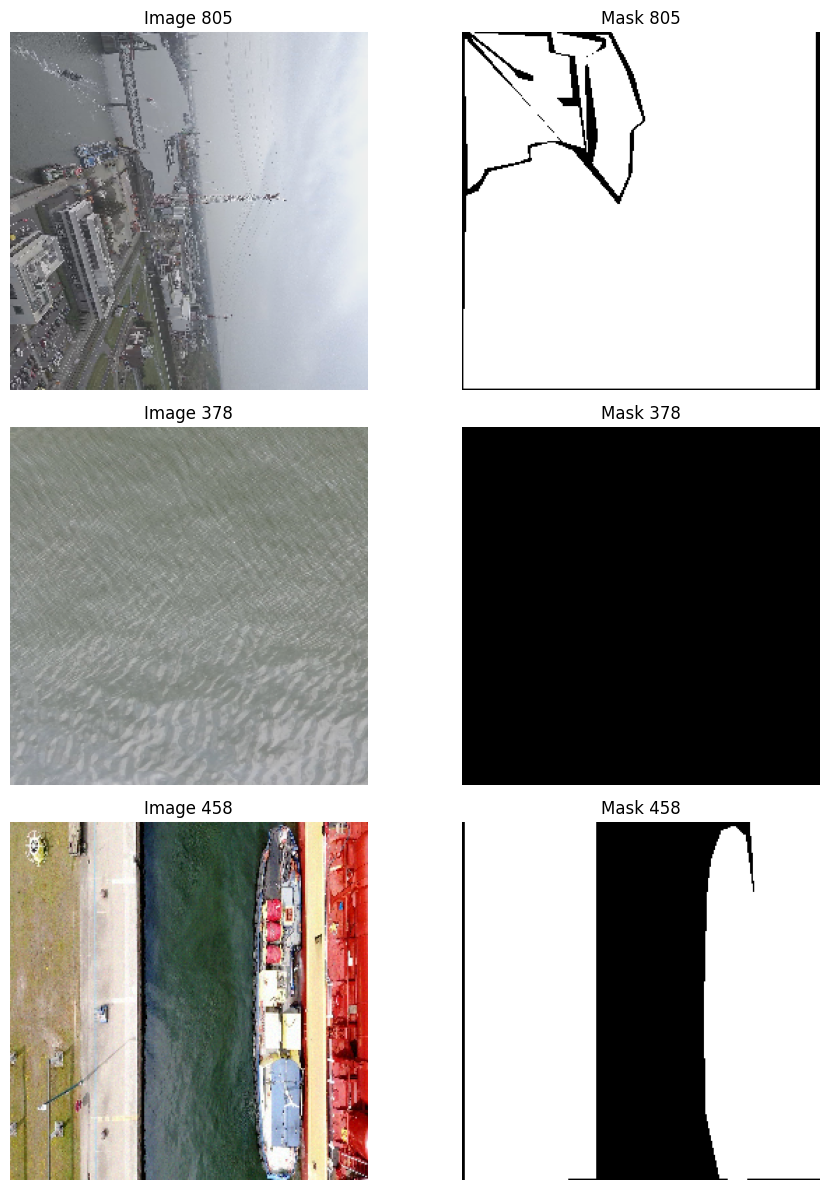

In [8]:
def visualize_samples(images, masks, num_samples=3):
    """Visualize preprocessed samples"""
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, idx in enumerate(indices):
        axes[i, 0].imshow(images[idx])
        axes[i, 0].set_title(f'Image {idx}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(masks[idx], cmap='gray')
        axes[i, 1].set_title(f'Mask {idx}')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train, 3)

## 11. Data Summary

In [9]:
print("\n" + "="*50)
print("PREPROCESSING SUMMARY")
print("="*50)
print(f"✓ Dataset: {DATASET_PATH}")
print(f"✓ Image type: {IMAGE_TYPE}")
print(f"✓ Image size: {IMG_HEIGHT}x{IMG_WIDTH}x{IMG_CHANNELS}")
print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Validation samples: {len(X_val)}")
print(f"✓ Test samples: {len(X_test)}")
print("\nFeatures:")
print("✓ SAR speckle noise reduction (Lee filter)")
print("✓ SAR log-scaling + z-score normalization")
print("✓ RGB normalization to [0,1]")
print("✓ Binary masks (oil=1, background=0)")
print("✓ Geometric augmentation (flips, rotations)")
print("✓ Photometric augmentation (brightness, contrast, noise)")
print("✓ SAR-specific augmentation (speckle simulation)")
print("\nData ready for model training!")
print("="*50)


PREPROCESSING SUMMARY
✓ Dataset: DataSet
✓ Image type: RGB
✓ Image size: 256x256x3
✓ Training samples: 811
✓ Validation samples: 203
✓ Test samples: 254

Features:
✓ SAR speckle noise reduction (Lee filter)
✓ SAR log-scaling + z-score normalization
✓ RGB normalization to [0,1]
✓ Binary masks (oil=1, background=0)
✓ Geometric augmentation (flips, rotations)
✓ Photometric augmentation (brightness, contrast, noise)
✓ SAR-specific augmentation (speckle simulation)

Data ready for model training!


In [1]:
!pip install tensorflow keras

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------------
# 1. Define U-Net Architecture
# -------------------------------
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


# -------------------------------
# 2. Define Losses & Metrics
# -------------------------------
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


# -------------------------------
# 3. Compile Model
# -------------------------------
model = unet_model(input_size=(256, 256, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=dice_loss,
              metrics=['accuracy', dice_coefficient])

model.summary()


# -------------------------------
# 4. Train Model
# -------------------------------
EPOCHS = 5
BATCH_SIZE = 8

history = model.fit(
    X_train, y_train[..., np.newaxis],   # expand dims for masks (H,W) → (H,W,1)
    validation_data=(X_val, y_val[..., np.newaxis]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


# -------------------------------
# 5. Evaluate on Test Set
# -------------------------------
test_loss, test_acc, test_dice = model.evaluate(X_test, y_test[..., np.newaxis])
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test Dice: {test_dice:.4f}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1187s 12s/step - accuracy: 0.6300 - dice_coefficient: 0.7385 - loss: 0.2620 - val_accuracy: 0.6024 - val_dice_coefficient: 0.7285 - val_loss: 0.2760
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1161s 11s/step - accuracy: 0.6317 - dice_coefficient: 0.7702 - loss: 0.2302 - val_accuracy: 0.6024 - val_dice_coefficient: 0.7285 - val_loss: 0.2760
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1358s 13s/step - accuracy: 0.6317 - dice_coefficient: 0.7709 - loss: 0.2303 - val_accuracy: 0.6024 - val_dice_coefficient: 0.7285 - val_loss: 0.2760
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1394s 14s/step - accuracy: 0.6317 - dice_coefficient: 0.7703 - loss: 0.2302 - val_accuracy: 0.6024 - val_dice_coefficient: 0.7285 - val_loss: 0.2760
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 1450s 14s/step - accuracy: 0.6317 - dice_coefficient: 0.7669 - loss: 0.2316 - val_accuracy: 0.6024 - val_dice_coefficient: 0.7285 - val_loss: 0.2760
8/8 ━━━━━━━━━━━━━━━━━━━━ 136s 14s/step - accuracy: 0.6290 - 